<a href="https://colab.research.google.com/github/saeedzou/DeepLearning1401-01/blob/main/Assignment%204/q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
import gc
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
!pip install -q transformers
from transformers import BertTokenizer
from transformers import BertModel
!pip install -q hazm
import hazm
import os
import seaborn as sns
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
!git clone https://github.com/amnghd/Persian_poems_corpus.git

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 10.65 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (148/148), done.


I selected 10 poets with around 10-15k number of beyts so that the combined dataset is almost balanaced.

In [3]:
poets_dict = {}
for poet in os.listdir('Persian_poems_corpus/normalized'):
  with open(f'Persian_poems_corpus/normalized/{poet}', 'r', encoding='utf-8') as f:
      poem = [line.strip() for line in f.readlines()]
      poem = [verse for verse in poem if len(verse)>0]
  poets_dict[poet.split('_')[0]] = len(poem)
selected_poets = {poet:num_mesras for poet, num_mesras in poets_dict.items() if num_mesras>20000 and num_mesras<31000}

In [4]:
data = []
for poet in selected_poets.keys():
  df = pd.read_csv(os.path.join('Persian_poems_corpus/normalized', poet + '_norm.txt'), header=None, names=['text'])
  if len(df) % 2 == 1:
    df = df[:-1]
  df = pd.DataFrame({'text': [df.iloc[i]['text'] + ' [SEP] ' + df.iloc[i+1]['text'] for i in range(0, len(df), 2)]})
  print(poet, ", number of beyts: ", len(df))
  data.append(df)
result = pd.concat([df.assign(index=i) for i, df in enumerate(data)], axis=0, ignore_index=True)
result = result.sample(frac=1).reset_index(drop=True)

anvari , number of beyts:  13307
farrokhi , number of beyts:  11985
vahshi , number of beyts:  10494
naserkhosro , number of beyts:  10748
seyf , number of beyts:  13008
nezari , number of beyts:  10229
salman , number of beyts:  13015
kamal , number of beyts:  15177
ouhadi , number of beyts:  14620
shahnematollah , number of beyts:  14957


In [5]:
# split data into train and val and test
trainset = result.iloc[:int(len(result)*0.8)].values
valset = result.iloc[int(len(result)*0.8):int(len(result)*0.9)].values
testset = result.iloc[int(len(result)*0.9):].values
# print the length of each dataset
print('train: ', len(trainset))
print('val: ', len(valset))
print('test: ', len(testset))

train:  102032
val:  12754
test:  12754


In [6]:
# calculate max length of poems
max_len = 0
for poem in trainset:
    if len(poem[0].split()) > max_len:
        max_len = len(poem[0].split())
print('max length of poems: ', max_len)
# print the poem with max length
print('poem with max length: ', trainset[np.argmax([len(poem[0].split()) for poem in trainset])][0])

max length of poems:  27
poem with max length:  نام وننگ و فخر و عار و عز وذل و نوش وزهر [SEP] شادی و غم سعد و نحس و تاج و بند و تخت و دار


In [7]:
# define a dataset class
class PoemDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.texts = [tokenizer(text, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt') for text in self.data[:, 0]]
        self.labels = [poet for poet in self.data[:, 1]]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.texts[index], torch.tensor(self.labels[index]).long()

In [8]:
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-base-parsbert-uncased')
train_dataset = PoemDataset(trainset, tokenizer, max_len)
val_dataset = PoemDataset(valset, tokenizer, max_len)
test_dataset = PoemDataset(testset, tokenizer, max_len)

In [9]:
# dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [10]:
ParsBERT = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
# freeze ParsBERT parameters
for param in ParsBERT.parameters():
    param.requires_grad = False
# define a model class
class PoemClassifier(nn.Module):
    def __init__(self, ParsBERT, num_classes):
        super(PoemClassifier, self).__init__()
        self.ParsBERT = ParsBERT
        self.classifier = nn.Linear(768, num_classes)
    
    def forward(self, input_ids, attention_mask):
        output = self.ParsBERT(input_ids=input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        return output

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# define a function for training
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (outputs.argmax(1) == labels).sum().item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return train_losses, train_accs, val_losses, val_accs


# define a function for evaluating
def evaluate(model, val_loader, criterion, device):
    model = model.to(device)
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).sum().item()
    val_loss /= len(val_loader)
    val_acc /= len(val_loader.dataset)
    return val_loss, val_acc

In [ ]:
# train the model
gc.collect()
torch.cuda.empty_cache()
model = PoemClassifier(ParsBERT, len(selected_poets))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, optimizer, criterion, 5, device)

Epoch: 1/5, Train Loss: 2.2028, Train Acc: 0.1977, Val Loss: 2.1271, Val Acc: 0.2340
Epoch: 2/5, Train Loss: 2.1550, Train Acc: 0.2240, Val Loss: 2.1207, Val Acc: 0.2427
Epoch: 3/5, Train Loss: 2.1377, Train Acc: 0.2331, Val Loss: 2.1113, Val Acc: 0.2448
Epoch: 4/5, Train Loss: 2.1311, Train Acc: 0.2362, Val Loss: 2.0641, Val Acc: 0.2678
Epoch: 5/5, Train Loss: 2.1231, Train Acc: 0.2387, Val Loss: 2.0953, Val Acc: 0.2678


In [ ]:
# save the model
torch.save(model.state_dict(), 'poem_classifier.pt')
# test the model
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 2.1113, Test Acc: 0.2616


In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
# define a function for predicting
def predict(model, poem, tokenizer, max_len, device):
    model = model.to(device)
    model.eval()
    poem = tokenizer(poem, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')
    poem = poem.to(device)
    output = model(input_ids=poem['input_ids'].squeeze(1), attention_mask=poem['attention_mask'])
    return output.argmax(1).item()

# report the results, classification report and confusion matrix
y_true = []
y_pred = []
for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
    y_true.extend(labels.tolist())
    y_pred.extend(outputs.argmax(1).tolist())

                precision    recall  f1-score   support

        anvari       0.22      0.17      0.19      1381
      farrokhi       0.29      0.35      0.32      1241
        vahshi       0.00      0.00      0.00      1045
   naserkhosro       0.30      0.25      0.27      1074
          seyf       0.43      0.06      0.10      1328
        nezari       0.22      0.22      0.22      1031
        salman       0.22      0.18      0.19      1316
         kamal       0.23      0.37      0.29      1431
        ouhadi       0.23      0.25      0.24      1435
shahnematollah       0.31      0.66      0.42      1472

      accuracy                           0.26     12754
     macro avg       0.25      0.25      0.22     12754
  weighted avg       0.25      0.26      0.23     12754



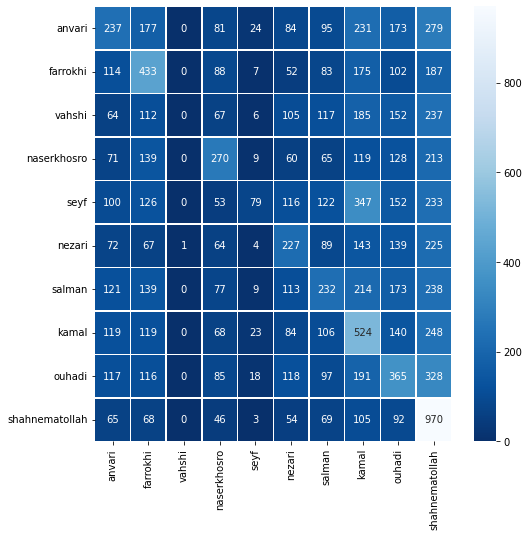

f1 score:  0.22477351150183283


In [ ]:
print(classification_report(y_true, y_pred, target_names=selected_poets.keys()))
fig = plt.figure(figsize=(8, 8))
ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, linewidth=.5, fmt="d", cmap="Blues_r",
                 xticklabels=selected_poets.keys(), yticklabels=selected_poets.keys())
plt.show()
print("f1 score: ", f1_score(y_true, y_pred, average='macro'))

Note that because the poems were selected so that their number of beyts are in the same range, the accuracy might seem very low. But if you choose a poet with a high number of beyts, the accuracy might increase to 40%

# Fine-tuning with SGD and Adam

In [ ]:
# define another model where ParsBERT is not frozen
ParsBERT = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
gc.collect()
torch.cuda.empty_cache()
model = PoemClassifier(ParsBERT, len(selected_poets))
# train the model once with SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# we want to measure perplexity before and after training. select 1000 unbiased samples from the test set
# Get unique labels
labels = np.unique(testset[:, 1])
# Initialize empty list to store samples
samples = []
# Loop over unique labels
for label in labels:
    # Get indices of samples with the current label
    indices = np.where(testset[:, 1] == label)[0]
    # Randomly select 100 samples from those indices and get the corresponding samples
    samples.append(testset[np.random.choice(indices, 100, replace=False)])
# Concatenate all samples into a single numpy array
samples_dataset = PoemDataset(np.concatenate(samples), tokenizer, max_len)
# Create a dataloader for the samples
samples_loader = torch.utils.data.DataLoader(samples_dataset, batch_size=32, shuffle=True)
# test the model
test_loss, test_acc = evaluate(model, samples_loader, criterion, device)
# calculate perplexity
perplexity = np.exp(test_loss)
print(f'Perplexity before training: {perplexity:.4f}')
# train the model once with SGD optimizer
train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, optimizer, criterion, 5, device)
# save the model
torch.save(model.state_dict(), 'poem_classifier_sgd.pt')
# test the model
test_loss, test_acc = evaluate(model, samples_loader, criterion, device)
# calculate perplexity
perplexity = np.exp(test_loss)
print(f'Perplexity after training: {perplexity:.4f}')
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
# report the results, classification report and confusion matrix
y_true = []
y_pred = []
for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
    y_true.extend(labels.tolist())
    y_pred.extend(outputs.argmax(1).tolist())
print(classification_report(y_true, y_pred, target_names=selected_poets.keys()))
print(confusion_matrix(y_true, y_pred))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perplexity before training: 10.4357


In [12]:
# define another model where ParsBERT is not frozen
ParsBERT = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
gc.collect()
torch.cuda.empty_cache()
model = PoemClassifier(ParsBERT, len(selected_poets))
# train the model with Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
# we want to measure perplexity before and after training. select 1000 unbiased samples from the test set
# Get unique labels
labels = np.unique(testset[:, 1])
# Initialize empty list to store samples
samples = []
# Loop over unique labels
for label in labels:
    # Get indices of samples with the current label
    indices = np.where(testset[:, 1] == label)[0]
    # Randomly select 100 samples from those indices and get the corresponding samples
    samples.append(testset[np.random.choice(indices, 100, replace=False)])
# Concatenate all samples into a single numpy array
samples_dataset = PoemDataset(np.concatenate(samples), tokenizer, max_len)
# Create a dataloader for the samples
samples_loader = torch.utils.data.DataLoader(samples_dataset, batch_size=32, shuffle=True)
# test the model
test_loss, test_acc = evaluate(model, samples_loader, criterion, device)
# calculate perplexity
perplexity = np.exp(test_loss)
print(f'Perplexity before training: {perplexity:.4f}')
# train the model once with SGD optimizer
train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, optimizer, criterion, 5, device)
# save the model
torch.save(model.state_dict(), 'poem_classifier_sgd.pt')
# test the model
test_loss, test_acc = evaluate(model, samples_loader, criterion, device)
# calculate perplexity
perplexity = np.exp(test_loss)
print(f'Perplexity after training: {perplexity:.4f}')
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
# report the results, classification report and confusion matrix
y_true = []
y_pred = []
for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
    y_true.extend(labels.tolist())
    y_pred.extend(outputs.argmax(1).tolist())


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perplexity before training: 10.2428
Epoch: 1/5, Train Loss: 1.6512, Train Acc: 0.4187, Val Loss: 1.3591, Val Acc: 0.5307
Epoch: 2/5, Train Loss: 1.1501, Train Acc: 0.6041, Val Loss: 1.1810, Val Acc: 0.5950
Epoch: 3/5, Train Loss: 0.8712, Train Acc: 0.7054, Val Loss: 1.0992, Val Acc: 0.6325
Epoch: 4/5, Train Loss: 0.6580, Train Acc: 0.7786, Val Loss: 1.0802, Val Acc: 0.6573
Epoch: 5/5, Train Loss: 0.4834, Train Acc: 0.8384, Val Loss: 1.1631, Val Acc: 0.6542
Perplexity after training: 3.1449
Test Loss: 1.1458, Test Acc: 0.6600


NameError: ignored

                precision    recall  f1-score   support

        anvari       0.61      0.48      0.54      1349
      farrokhi       0.76      0.77      0.77      1189
        vahshi       0.67      0.48      0.56      1044
   naserkhosro       0.77      0.75      0.76      1054
          seyf       0.83      0.64      0.72      1296
        nezari       0.63      0.60      0.62      1010
        salman       0.49      0.63      0.55      1293
         kamal       0.58      0.64      0.61      1523
        ouhadi       0.52      0.68      0.59      1458
shahnematollah       0.83      0.83      0.83      1538

      accuracy                           0.65     12754
     macro avg       0.67      0.65      0.65     12754
  weighted avg       0.67      0.65      0.66     12754



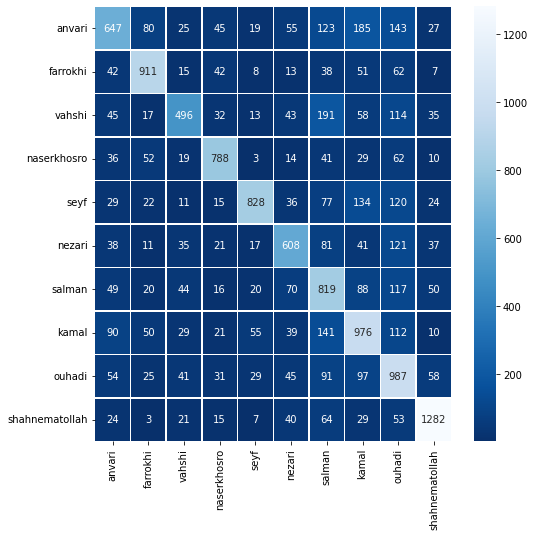

f1 score:  0.654083822810026


In [16]:
print(classification_report(y_true, y_pred, target_names=selected_poets.keys()))
fig = plt.figure(figsize=(8, 8))
ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, linewidth=.5, fmt="d", cmap="Blues_r",
                 xticklabels=selected_poets.keys(), yticklabels=selected_poets.keys())
plt.show()
print("f1 score: ", f1_score(y_true, y_pred, average='macro'))